In [166]:
import os 
import pandas as pd
import numpy as np
import subprocess

read_csv_cpp = False #True: process in the c++ libr the same vectors produced with numpy
                    # and processed with pandas.
                    # False: creates internally to c++ random vectors (with same size of)
                    # of those processed with pandas
                    # time to solution faster with False (no csv reading)
                    # time benchmark of the performance is the same with True or False
                    # (valuated only on the computational part, no I/O)

# Linux
# !g++ -o stats_multithread.exe main.cpp kernels.cpp -I/c/Users/Administrator/Libreries/boost_1_89_0/ -I/./
# !./test.exe 1000000 2 1000 4

# Windows
!g++ -o stats_multithread.exe main.cpp interface_vectors.cpp kernels.cpp -IC:\Users\Administrator\Libreries\boost_1_89_0 -I.

# generate 2 random vectors
for ii in range(2):
    dummy = np.random.rand(10**7)
    dummy_df = pd.Series(dummy)
    if ii == 0:
        vect = dummy_df.copy()
    else:
        vect = pd.concat([vect,dummy_df],axis=1)


In [167]:
import time
window_size = 100
start_pd = time.perf_counter()
rolling_corr = vect[0].rolling(window=window_size).mean
rolling_corr = vect[1].rolling(window=window_size).mean
rolling_corr = vect[0].rolling(window=window_size).corr(vect[1])
end_pd = time.perf_counter()
print(f"Rolling Correlation (Pandas): {end_pd - start_pd:.4f} secondi")

N_threads = 4
if (read_csv_cpp):
    vect.to_csv("file.csv", sep=';', index=False, header=False)
    !.\stats_multithread.exe path=.\file.csv w={window_size} num_threads={N_threads} >stdout
else:
    !.\stats_multithread.exe n={vect.shape[0]} w={window_size} num_threads={N_threads} >stdout

df = pd.read_csv("timing.csv", sep=";")  
print("Rolling Correlation c++ with different methods:\n")
for ii in range(df.shape[0]):
    print("- "+df.loc[ii,"method"] + " time to solution is: "+ str(df.loc[ii,"time"]))


Rolling Correlation (Pandas): 8.4257 secondi
Rolling Correlation c++ with different methods:

- parallel vectors input - parallel vector treatment time to solution is: 0.270753
- parallel vectors input - serial vector treatment time to solution is: 0.365928
- serial vectors input - parallel vector treatment time to solution is: 0.396189
- serial vectors input - serial vector treatment time to solution is: 1.37701


For two vectors with 10^7 elements the C++ library is at least **10 times** faster when running with parallelism.

Bottlneck of the C++ library is the reading of csv file. To improve the overall C++ one should go in binary. Here the pourpose is to compare the algos and not the full flow that may depends on where the data come from.

0  done
4  done
8  done
12  done


Text(0.5, 1.0, 'scaling of the time to solution varying array length \n time window = 10, N threads = 2')

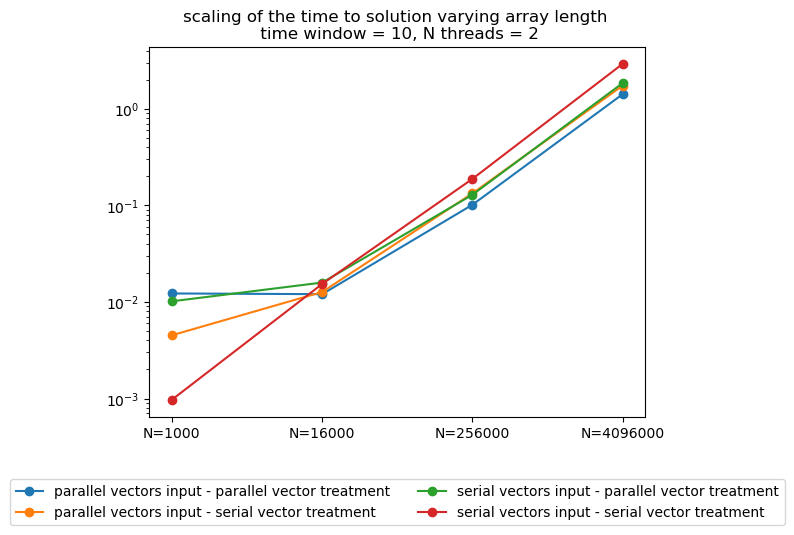

In [35]:
import pandas as pd
import numpy as np
import subprocess
import matplotlib.pyplot as plt
df_tot = None

for jj in range(0,13,4):
    N_tot = 10**3 * 2**jj
    subprocess.run([r".\stats_multithread.exe", str(N_tot), str(2), str(10), str(10)], check=True)

    print(jj, " done")
    df = pd.read_csv("timing.csv", sep=";")  
    df = df.rename(columns={"time": "N="+str(N_tot)}) 
    if df_tot is None:
        df_tot = df.copy()
    else:
        df_tot = df_tot.merge(df, on="method", how="outer")

num_cols = df_tot.columns.drop("method")

for ii in range(df_tot.shape[0]):
    y = df_tot.loc[ii, num_cols].values
    plt.plot(num_cols, y, marker="o", label=df_tot.loc[ii, "method"])
    plt.yscale("log")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.title("scaling of the time to solution varying array length \n time window = 10, N threads = 2")

0  done
1  done
2  done
3  done
4  done


Text(0.5, 1.0, 'scaling of the time to solution varying time window \n array length 2*10^5, N threads = 2')

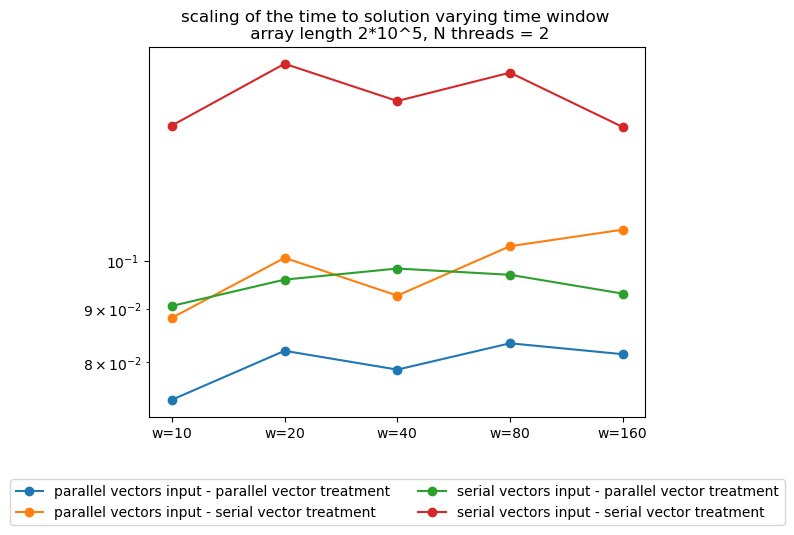

In [36]:
df_tot = None
for jj in range(5):
    window = 10 * 2**jj
    subprocess.run([r".\stats_multithread.exe", str(2*10**5), str(2), str(window), str(10)], check=True)

    print(jj, " done")
    df = pd.read_csv("timing.csv", sep=";")  
    df = df.rename(columns={"time": "w="+str(window)}) 
    if df_tot is None:
        df_tot = df.copy()
    else:
        df_tot = df_tot.merge(df, on="method", how="outer")

num_cols = df_tot.columns.drop("method")

plt.figure()
for ii in range(df_tot.shape[0]):
    y = df_tot.loc[ii, num_cols].values
    plt.plot(num_cols, y, marker="o", label=df_tot.loc[ii, "method"])
    plt.yscale("log")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.title("scaling of the time to solution varying time window \n array length 2*10^5, N threads = 2")

0  done
1  done
2  done
3  done
4  done


Text(0.5, 1.0, 'scaling of the time to solution varying N Threads \n array length 2*10^5, time window = 100')

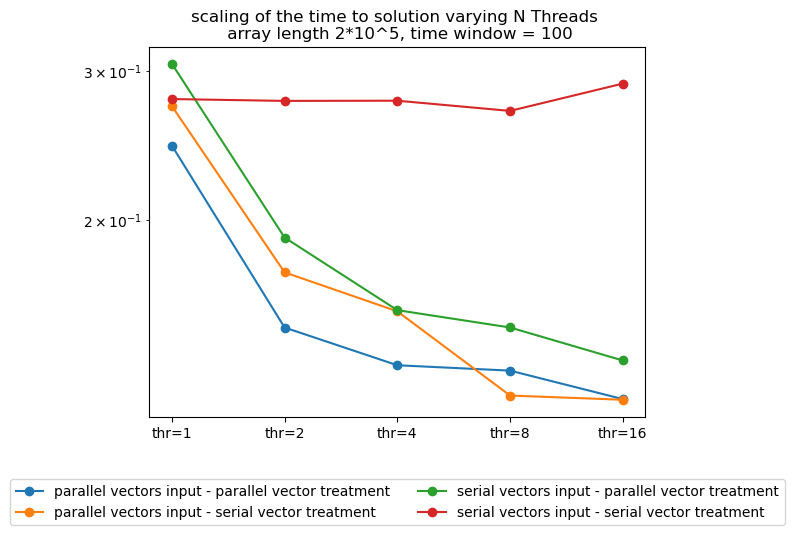

In [33]:
df_tot = None
for jj in range(5):
    threads = 2**jj
    subprocess.run([r".\stats_multithread.exe", str(2*10**5), str(threads), str(100), str(20)], check=True)

    print(jj, " done")
    df = pd.read_csv("timing.csv", sep=";")  
    df = df.rename(columns={"time": "thr="+str(threads)}) 
    if df_tot is None:
        df_tot = df.copy()
    else:
        df_tot = df_tot.merge(df, on="method", how="outer")

num_cols = df_tot.columns.drop("method")

plt.figure()
for ii in range(df_tot.shape[0]):
    y = df_tot.loc[ii, num_cols].values
    plt.plot(num_cols, y, marker="o", label=df_tot.loc[ii, "method"])
    plt.yscale("log")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.title("scaling of the time to solution varying N Threads \n array length 2*10^5, time window = 100")